In [ ]:
import os
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor

# default: Load the model on the available device(s)
model = Qwen3VLForConditionalGeneration.from_pretrained(
    "weathon/smolvlm2_anti_aesthetics_7b", dtype="auto", device_map="cuda"
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-4B-Instruct")
from datasets import load_dataset

import pandas as pd



In [3]:

df = pd.read_csv("rules.csv")
sign = lambda x: (x > 0) - (x < 0)
import pandas as pd
import re

df.columns = df.columns.str.strip()
df['Dimension'] = df['Dimension'].ffill()

df['dim_key'] = df['Dimension'].apply(lambda x: re.search(r'\((.*?)\)', x).group(1) if re.search(r'\((.*?)\)', x) else x)

guide = {
    dim_key: {
        f"{row['Option']}: {sign(int(row['Score']))+1}": ": " +str(row['Description']).strip()
        for _, row in group.iterrows()
    }
    for dim_key, group in df.groupby('dim_key')
}

score = {
    dim_key: {
        int(row['Score']): str(row['Option']).strip()
        for _, row in group.iterrows()
    }
    for dim_key, group in df.groupby('dim_key')
}



import json
import torch

def rate_single_image(image, t):
    results = {"scores": [], "preds": []}
    messages = []
    dims = []
    for dim in guide.keys():
        if dim in ["unsafe type", "hands", "face", "body", "safety", "lighting aesthetic", "symmetry"]:
            continue
        dims.append(dim)
        messages.append([
                    { 
                        "role": "user",
                        "content": [
                            {
                                "type":"text",
                                "text":f"Please rate this image for its {dim} quality. Use this guideline {guide[dim]}. Response a single number.",
                            },
                            {
                                "type": "image", 
                                "image":image.resize((512, 512))
                            }
                        ],
                    }])

    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt",
        padding=True
    ) 

    inputs = inputs.to(model.device)
    id_of_interest = processor.tokenizer.convert_tokens_to_ids(["0", "1", "2"])
    id_of_interest
    with torch.no_grad():
        logits = model(**inputs).logits
    logits = logits[:, -1, id_of_interest] 
    prob = torch.softmax(logits, dim=-1)
    for i in range(len(prob)):
        prob_of_interest = prob[i]
        score = torch.dot(prob_of_interest, torch.tensor([0, 1, 2], device=prob_of_interest.device).bfloat16())
        single_pred = prob_of_interest.argmax().item() 
        # results[f"{dim}_score"] = float(score)
        # results[f"{dim}_pred"] = single_pred
        print(dims[i], float(score), t) 
        results["scores"].append(float(score))
        results["preds"].append(single_pred)
    return results



In [4]:
from datasets import load_dataset
dataset = load_dataset("weathon/aas_img2img_comparisons")

README.md:   0%|          | 0.00/815 [00:00<?, ?B/s]

data/train-00000-of-00005.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00001-of-00005.parquet:   0%|          | 0.00/491M [00:00<?, ?B/s]

data/train-00002-of-00005.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00003-of-00005.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

data/train-00004-of-00005.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/284 [00:00<?, ? examples/s]

In [5]:
dataset = dataset["train"]
dataset

Dataset({
    features: ['index', 'image_distorted', 'prompt_distorted', 'flux_image', 'dance_image', 'dance_text_only', 'krea_text_only', 'original_prompt', 'flux_reward', 'dance_reward', 'nano_banananana_reward', 'dance_text_only_reward', 'flux_text_only_reward'],
    num_rows: 284
})

In [ ]:
res = []
def rate_dataset(sample):
    dance_rater = rate_single_image(sample["dance_image"], "dance")
    flux_reater = rate_single_image(sample["flux_image"], "flux")
    nano_banananana_rater = rate_single_image(sample["image_distorted"], "image_distorted")
    krea_text_only_rater = rate_single_image(sample["krea_text_only"][0], "krea_text_only")
    dance_text_only_rater = rate_single_image(sample["dance_text_only"][0], "dance_text_only")
    return {
        "dance_rater": dance_rater,
        "flux_rater": flux_reater,
        "nano_banananana_rater": nano_banananana_rater,
        "krea_text_only_rater": krea_text_only_rater,
        "dance_text_only_rater": dance_text_only_rater,
    }

for i in range(len(dataset)):
    sample = dataset[i]
    result = rate_dataset(sample)
    res.append(result)  

In [12]:
def add_columns(sample, i):
    res_line = res[i]
    sample["dance_rater"] = sum(res_line["dance_rater"]["scores"])
    sample["flux_rater"] = sum(res_line["flux_rater"]["scores"])
    sample["nano_banananana_rater"] = sum(res_line["nano_banananana_rater"]["scores"])
    sample["krea_text_only_rater"] = sum(res_line["krea_text_only_rater"]["scores"])
    sample["dance_text_only_rater"] = sum(res_line["dance_text_only_rater"]["scores"])
    return sample

In [13]:
dataset = dataset.map(add_columns, with_indices=True)

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

In [ ]:
dataset.push_to_hub("weathon/aas_img2img_comparisons")

In [1]:
dataset

NameError: name 'dataset' is not defined

In [58]:
from datasets import load_dataset
dataset = load_dataset("weathon/aas_img2img_comparisons")

In [60]:
dataset = dataset["train"]

In [ ]:
# dataset = dataset.remove_columns(["dance_image", "flux_image", "image_distorted", "krea_text_only", "dance_text_only"])

In [12]:
import numpy as np
import pandas as pd
df = pd.DataFrame(dataset)

In [37]:
dataset

Dataset({
    features: ['index', 'prompt_distorted', 'original_prompt', 'flux_reward', 'dance_reward', 'nano_banananana_reward', 'dance_text_only_reward', 'flux_text_only_reward', 'dance_rater', 'flux_rater', 'nano_banananana_rater', 'krea_text_only_rater', 'dance_text_only_rater'],
    num_rows: 284
})

In [43]:
selected = df[["nano_banananana_reward", "flux_reward", "dance_reward", "nano_banananana_rater", "flux_rater", "dance_rater", "dance_text_only_rater", "dance_text_only_reward", "krea_text_only_rater", "flux_text_only_reward"]]

In [29]:
selected.loc[:, "flux_reward_delta"] = selected["flux_reward"] - selected["nano_banananana_reward"] 
selected.loc[:, "dance_reward_delta"] = selected["dance_reward"] - selected["nano_banananana_reward"]
selected.loc[:, "flux_rater_delta"] = selected["flux_rater"] - selected["nano_banananana_rater"] 
selected.loc[:, "dance_rater_delta"] = selected["dance_rater"] - selected["nano_banananana_rater"]

In [ ]:
(selected["flux_reward"] - selected["flux_text_only_reward"]).mean() 

-1.4057502862800595

In [ ]:
selected["flux_reward_delta"].mean(), selected["dance_reward_delta"].mean(), selected["flux_rater_delta"].mean(), selected["dance_rater_delta"].mean()

(2.1753383444517223,
 3.1266368702972227,
 0.6354876284448194,
 1.0711812971973083)

In [57]:
dataset

Dataset({
    features: ['index', 'prompt_distorted', 'original_prompt', 'flux_reward', 'dance_reward', 'nano_banananana_reward', 'dance_text_only_reward', 'flux_text_only_reward', 'dance_rater', 'flux_rater', 'nano_banananana_rater', 'krea_text_only_rater', 'dance_text_only_rater'],
    num_rows: 284
})

In [90]:
import random
idx = [51, 261, 191, 244] + random.sample(list(range(len(dataset))), 1)


In [92]:
idx

[51, 261, 191, 244, 129]

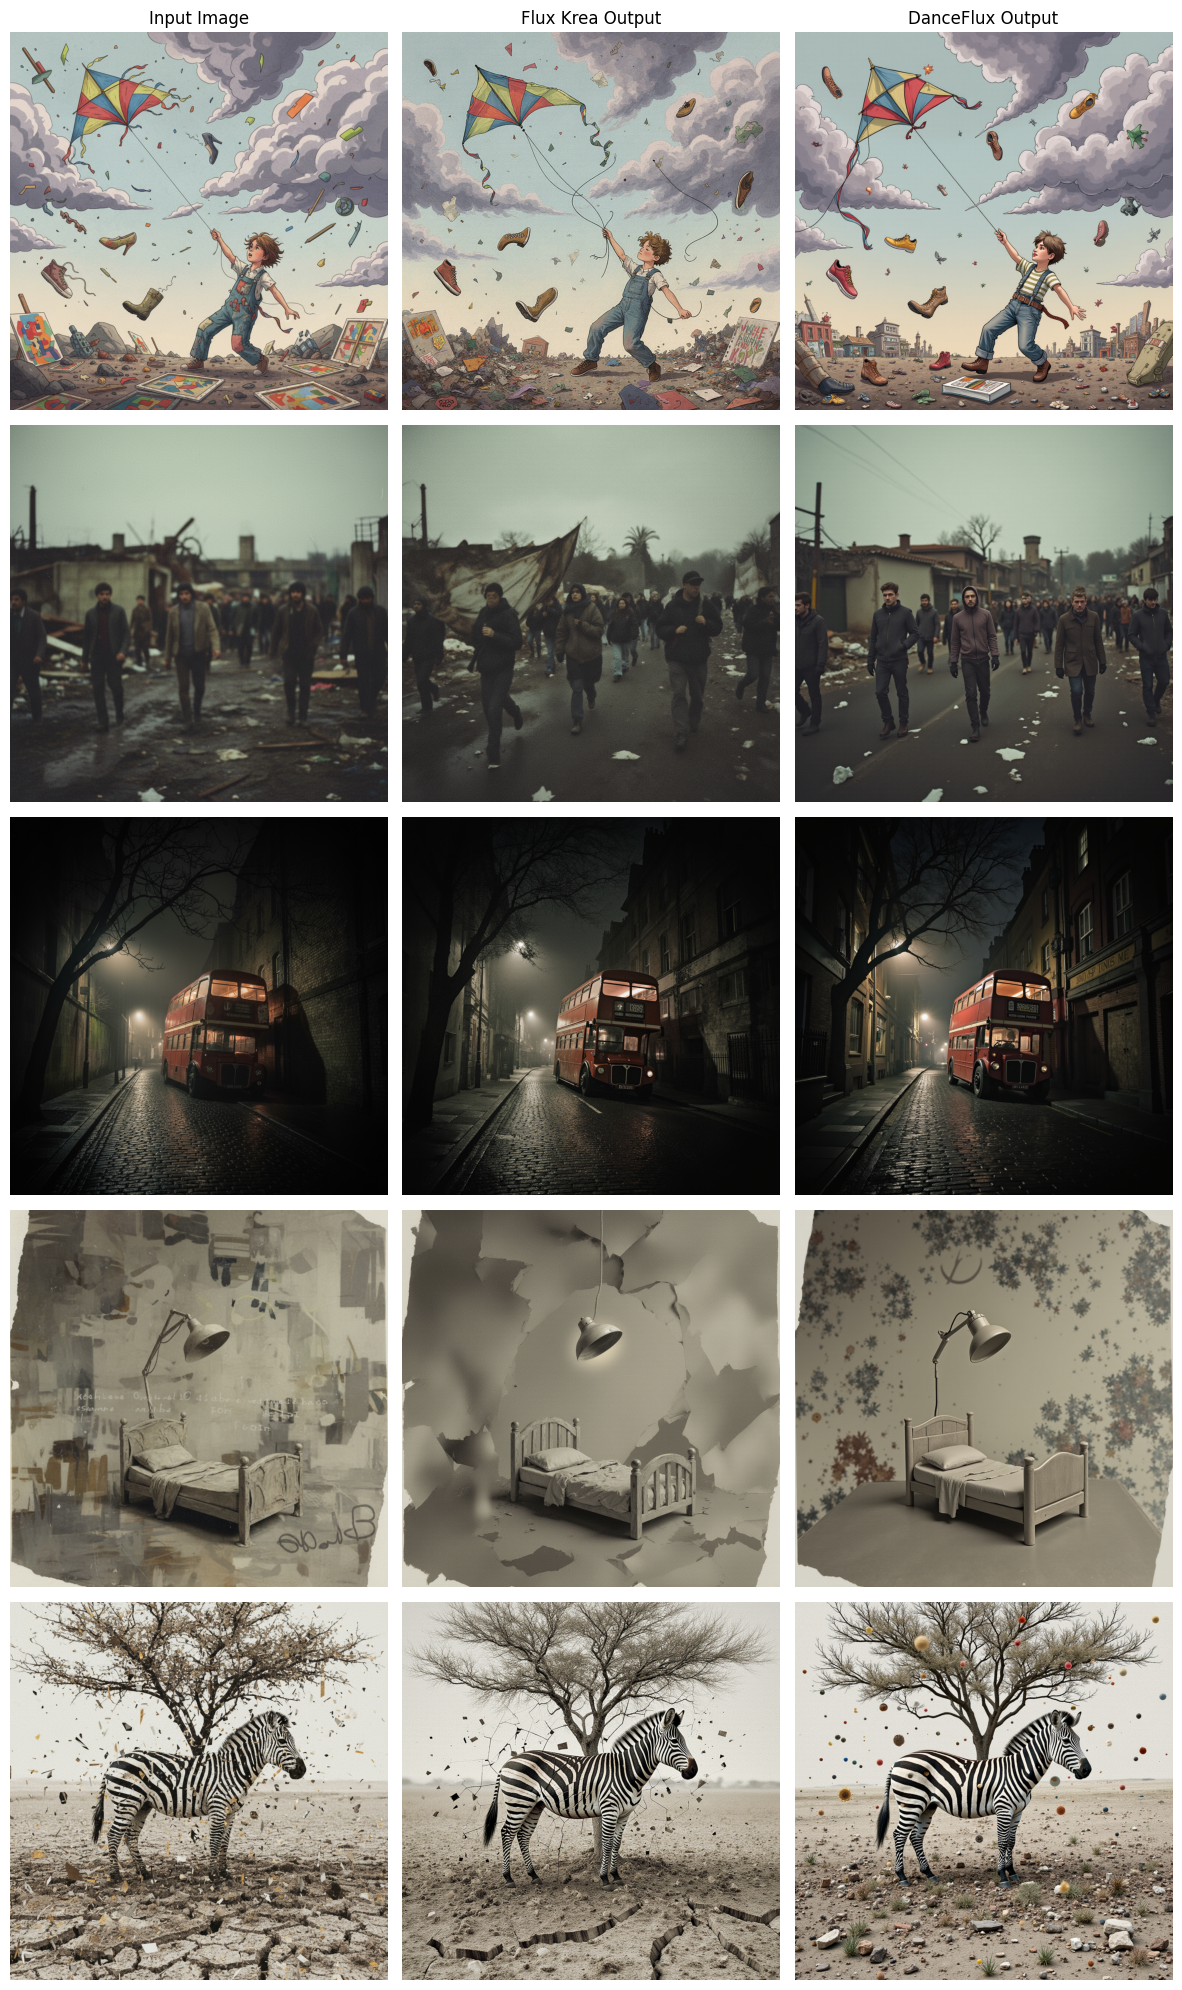

In [91]:
import pylab
pylab.figure(figsize=(12, 20))
for i in range(len(idx)): 
    pylab.subplot(5, 3, i*3+1)
    pylab.imshow(dataset[idx[i]]["image_distorted"]) 
    pylab.axis("off")
    if i == 0:
        pylab.title("Input Image")
    pylab.subplot(5, 3, i*3+2)
    pylab.imshow(dataset[idx[i]]["flux_image"])
    pylab.axis("off")
    if i == 0:
        pylab.title("Flux Krea Output")
    pylab.subplot(5, 3, i*3+3)
    pylab.imshow(dataset[idx[i]]["dance_image"])
    pylab.axis("off")
    if i == 0:
        pylab.title("DanceFlux Output")
pylab.tight_layout()
pylab.show()